In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-01-26 16:33:25'

# wip

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [41]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [61]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db2 = DbAccessor('hshah1_005_bptt_lstm_dense_sweep', timestep_col_name="timestep", local=False, gc=True)
comment2 = 'step_size_sweep'
db3 = DbAccessor('hshah1_007_bptt_lstm_echostate', timestep_col_name="timestep", local=False, gc=True)
comment3 = 'step_size_sweep'
db4 = DbAccessor('hshah1_006_tbptt_lstm_dense_sweep', timestep_col_name="timestep", local=False, gc=True)
comment4='tbptt_step_size_sweep'
db5 = DbAccessor('khurram_ColumarNetworkSweepInit', cfg_primary_key="run", timestep_col_name="step", local=False, gc2=True)


In [5]:
#pd.read_sql(f'select * from runs', db2.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db2.conn)

,run_id,seed,db,db_prefix,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,221738228,0,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738228,step_size_sweep,finished,2100000,35,0.004576,0.969842,0.004246,0.9737,19:19:27.674251
1,221738238,1,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738238,step_size_sweep,finished,2100000,35,0.002441,0.985616,0.003732,0.9767,19:22:30.606223
2,221738249,2,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738249,step_size_sweep,finished,2100000,35,0.002485,0.986207,0.003541,0.9790,19:33:24.249115
3,221738278,5,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738278,step_size_sweep,finished,2100000,35,0.002459,0.985196,0.003790,0.9762,19:22:20.148113
4,221738289,6,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738289,step_size_sweep,finished,2100000,35,0.003211,0.981142,0.004248,0.9731,19:15:42.486371
5,221738298,7,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738298,step_size_sweep,finished,2100000,35,0.002695,0.984005,0.003786,0.9769,19:18:01.582095
6,221738309,8,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738309,step_size_sweep,finished,2100000,35,0.002547,0.985281,0.003707,0.9768,19:27:45.102109
7,221738319,9,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.100,221738319,step_size_sweep,finished,2100000,35,0.002896,0.982100,0.003759,0.9767,19:22:35.972265
8,221738340,1,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.500,221738340,step_size_sweep,finished,2100000,35,0.016746,0.895812,0.016583,0.8948,19:24:44.884962
9,221738349,2,hshah1_005_bptt_lstm_dense_sweep,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,0,100000,1,0.500,221738349,step_size_sweep,finished,2100000,35,0.032627,0.776418,0.033360,0.7732,19:22:33.703980


In [6]:
#pd.read_sql(f'select * from runs', db3.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db3.conn)

,run_id,seed,db,db_prefix,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,221737490,1,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737490,step_size_sweep,finished,2100000,35,0.078631,0.383619,0.078017,0.3948,16:45:19.847275
1,221737500,2,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737500,step_size_sweep,finished,2100000,35,0.077957,0.409193,0.078330,0.4012,16:48:51.012418
2,221737510,3,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737510,step_size_sweep,finished,2100000,35,0.078333,0.427827,0.078430,0.4247,16:43:50.721108
3,221737521,4,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737521,step_size_sweep,finished,2100000,35,0.078381,0.422768,0.078040,0.4303,16:47:46.762724
4,221737531,5,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737531,step_size_sweep,finished,2100000,35,0.076967,0.436108,0.076761,0.4466,17:00:44.512493
5,221737541,6,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737541,step_size_sweep,finished,2100000,35,0.076993,0.437611,0.077308,0.4429,16:53:36.691781
6,221737551,7,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737551,step_size_sweep,finished,2100000,35,0.079388,0.410011,0.079582,0.4095,16:51:56.923531
7,221737561,8,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737561,step_size_sweep,finished,2100000,35,0.079015,0.386828,0.078467,0.4131,16:51:49.411164
8,221737572,9,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.100,221737572,step_size_sweep,finished,2100000,35,0.077283,0.450122,0.077277,0.4443,16:49:38.740545
9,221737582,0,hshah1_007_bptt_lstm_echostate,hshah1_,step_size_sweep,2100000,32,1,LSTM,0,1,100000,1,0.500,221737582,step_size_sweep,finished,2100000,35,0.068262,0.506913,0.068905,0.5070,16:46:28.868975


In [7]:
#pd.read_sql(f'select * from runs', db4.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db4.conn)

,run_id,seed,db,db_prefix,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,221737523,1,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221737523,tbptt_step_size_sweep,finished,2100000,35,0.038799,0.726659,0.037643,0.7327,17:44:14.481938
1,221737534,2,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221737534,tbptt_step_size_sweep,finished,2100000,35,0.041210,0.706436,0.040991,0.7094,17:34:50.105019
2,221737544,3,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221737544,tbptt_step_size_sweep,finished,2100000,35,0.038779,0.724602,0.039126,0.7260,17:42:40.843029
3,221737554,4,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221737554,tbptt_step_size_sweep,finished,2100000,35,0.041520,0.702069,0.040881,0.7066,17:33:05.146432
4,221737594,8,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221737594,tbptt_step_size_sweep,finished,2100000,35,0.041138,0.712475,0.042645,0.6983,17:47:55.388547
5,221738005,9,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,221738005,tbptt_step_size_sweep,finished,2100000,35,0.041173,0.713342,0.041789,0.7036,17:34:35.485921
6,221738015,0,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,221738015,tbptt_step_size_sweep,finished,2100000,35,0.044730,0.675231,0.045579,0.6722,17:38:11.354474
7,221738026,1,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,221738026,tbptt_step_size_sweep,finished,2100000,35,0.043880,0.683744,0.042049,0.7047,17:39:20.889029
8,221738066,5,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,221738066,tbptt_step_size_sweep,finished,2100000,35,0.048301,0.649262,0.046776,0.6614,17:33:19.978822
9,221738076,6,hshah1_006_tbptt_lstm_dense_sweep,hshah1_,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,221738076,tbptt_step_size_sweep,finished,2100000,35,0.044901,0.677558,0.044588,0.6768,17:37:44.164934


In [8]:
pd.read_sql(f'select * from runs where step_size=1e-1 and init=1', db5.conn)

,features,init,name,run,seed,step_size,steps
0,63,1.0,ColumarNetworkSweepInit,15,0,1e-1,2100000
1,63,1.0,ColumarNetworkSweepInit,21,1,1e-1,2100000
2,63,1.0,ColumarNetworkSweepInit,100,21,1e-1,2100000
3,63,1.0,ColumarNetworkSweepInit,101,22,1e-1,2100000
4,63,1.0,ColumarNetworkSweepInit,102,23,1e-1,2100000
5,63,1.0,ColumarNetworkSweepInit,103,24,1e-1,2100000
6,63,1.0,ColumarNetworkSweepInit,104,25,1e-1,2100000
7,63,1.0,ColumarNetworkSweepInit,105,26,1e-1,2100000
8,63,1.0,ColumarNetworkSweepInit,106,27,1e-1,2100000
9,63,1.0,ColumarNetworkSweepInit,107,28,1e-1,2100000


In [70]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    runs = []
    invalid_count = 0
    if nocomment:
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        if len(r) !=0:
            runs = r
    else:
        for run in suitable_runs:
            if condition == []:
                r = pd.read_sql(f'select {pkey_col} from runs where run_id={run[0]} and comment="{comment}"', db.conn).values
                invalid_r = pd.read_sql(f'select {pkey_col} from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
            elif len(condition) == 1:
                r = pd.read_sql(f'select {pkey_col} from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}" ', db.conn).values
                invalid_r = pd.read_sql(f'select {pkey_col} from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
            elif len(condition) == 2:
                r = pd.read_sql(f'select {pkey_col} from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}" and {condition[1][0]} = "{condition[1][1]}" ', db.conn).values
                invalid_r = pd.read_sql(f'select {pkey_col} from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
            if len(r) !=0 and np.all(invalid_r != r):
                runs.append(r[0])
            elif len(r) !=0 and np.all(invalid_r == r):
                invalid_count += 1

    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'accuracy'
    else:
        col = 'acc'
        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col)[:NSTEPS].to_numpy().reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col)[:NSTEPS].to_numpy().reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col)[:NSTEPS].index.to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    linewidth = plt.rcParams["lines.linewidth"]
    if linestyle == ":":
        linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        #plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle)
        plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.3, color=color)

In [10]:
pd.read_sql(f'select step, accuracy from error_table join runs on runs.run = error_table.run where step_size = 1e-1 and init = 1 and features = 63 order by step DESC;', db5.conn)
r = pd.read_sql(f'select run from runs where step_size = 0.1 and init = 1.0  ', db5.conn)
r.to_numpy().squeeze()

array([ 15,  21, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127])

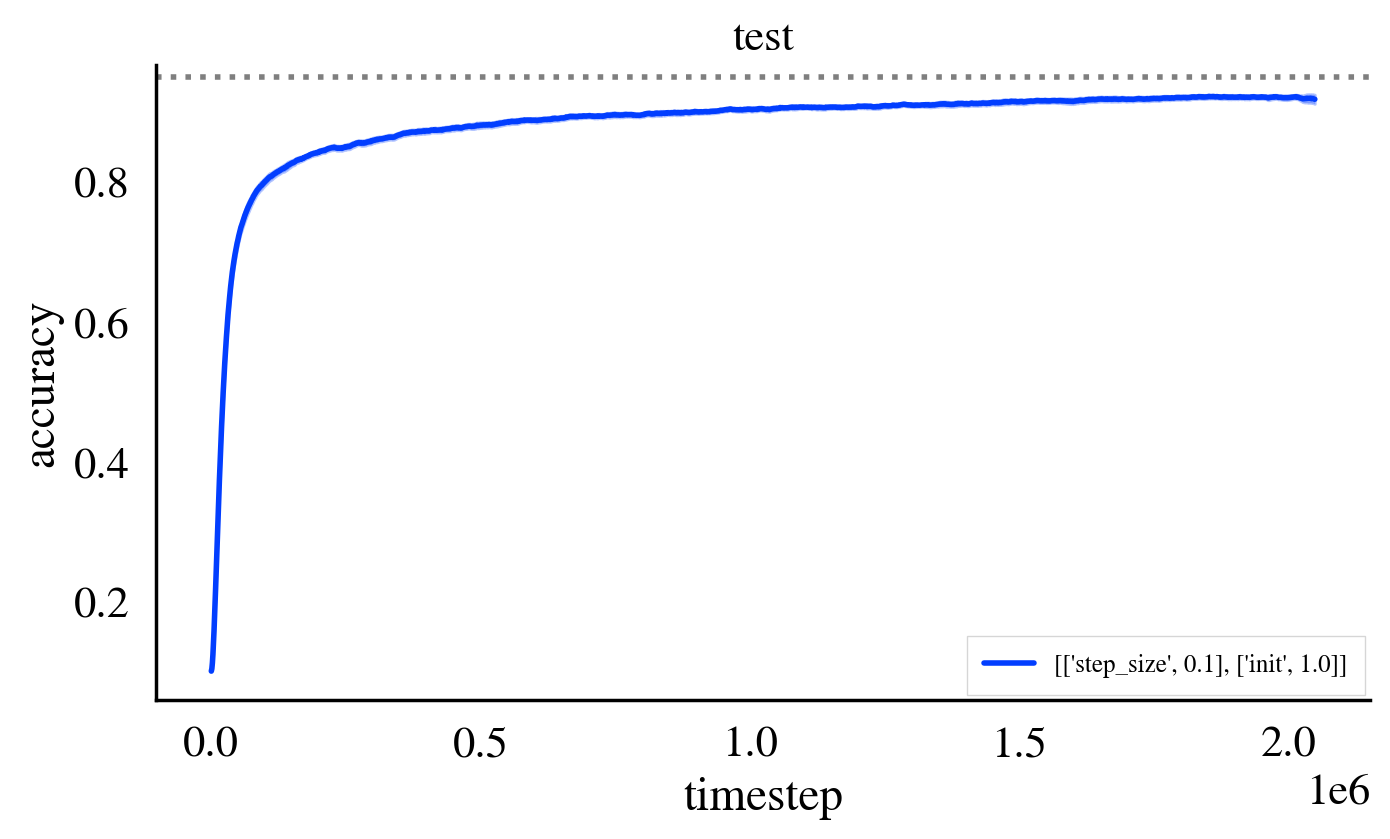

In [87]:
plt_name = f'test'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 2000
conditions = [['step_size', 1e-1],
             ['init', 1.0]]

plt_with_err("", 2050, 2000000, db5, colors[color_idx], str(conditions), conditions, "error_table", pkey_col = "run", nocomment=True)
color_idx+=1



plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

## Training accuracy plot

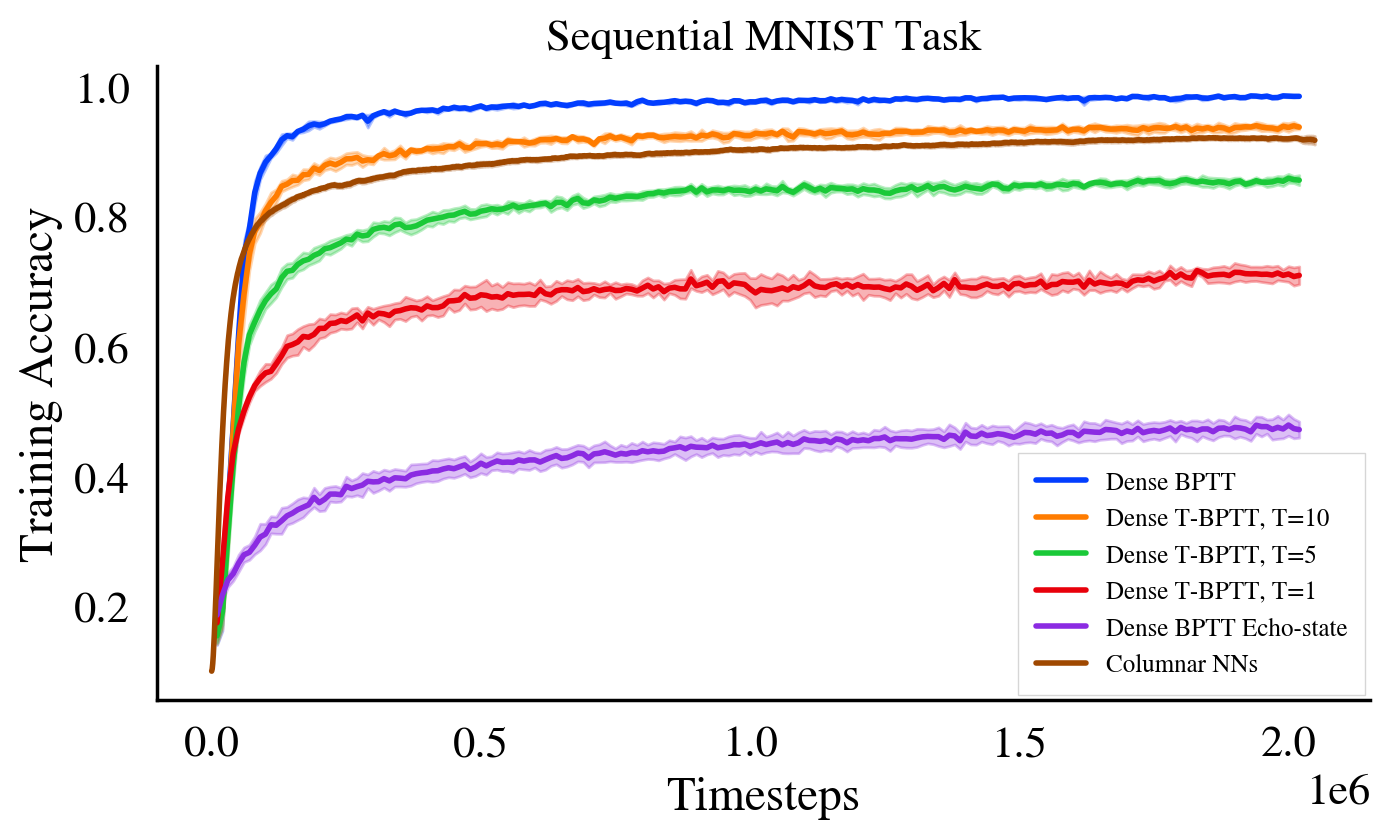

In [88]:
plt_name = f'Sequential MNIST Task'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Training Accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

#TODO make 204
NENTRIES = 202 # num entries to plot
min_steps =  2000000 # min timesteps that should exist for a run to qualify
conditions = [['step_size', 0.05]]
plt_with_err(comment2, NENTRIES, min_steps, db2, colors[color_idx], "Dense BPTT", conditions, "training_metrics", True)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 10]]

plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=10", conditions, "training_metrics", True)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 5]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=5", conditions, "training_metrics", True)
color_idx+=1

conditions = [['step_size', 0.1], ['truncation_length', 1]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=1", conditions, "training_metrics", True,)
color_idx+=1

conditions = [['step_size', 0.5]]
plt_with_err(comment3, NENTRIES, min_steps, db3, colors[color_idx], "Dense BPTT Echo-state", conditions, "training_metrics", True)
color_idx+=1

conditions = [['step_size', 1e-1],
             ['init', 1.0]]
plt_with_err("", 2050, min_steps, db5, colors[color_idx], "Columnar NNs", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_sMNIST_training_only.pdf', bbox_inches='tight')
plt.show()

## Test accuracy plot

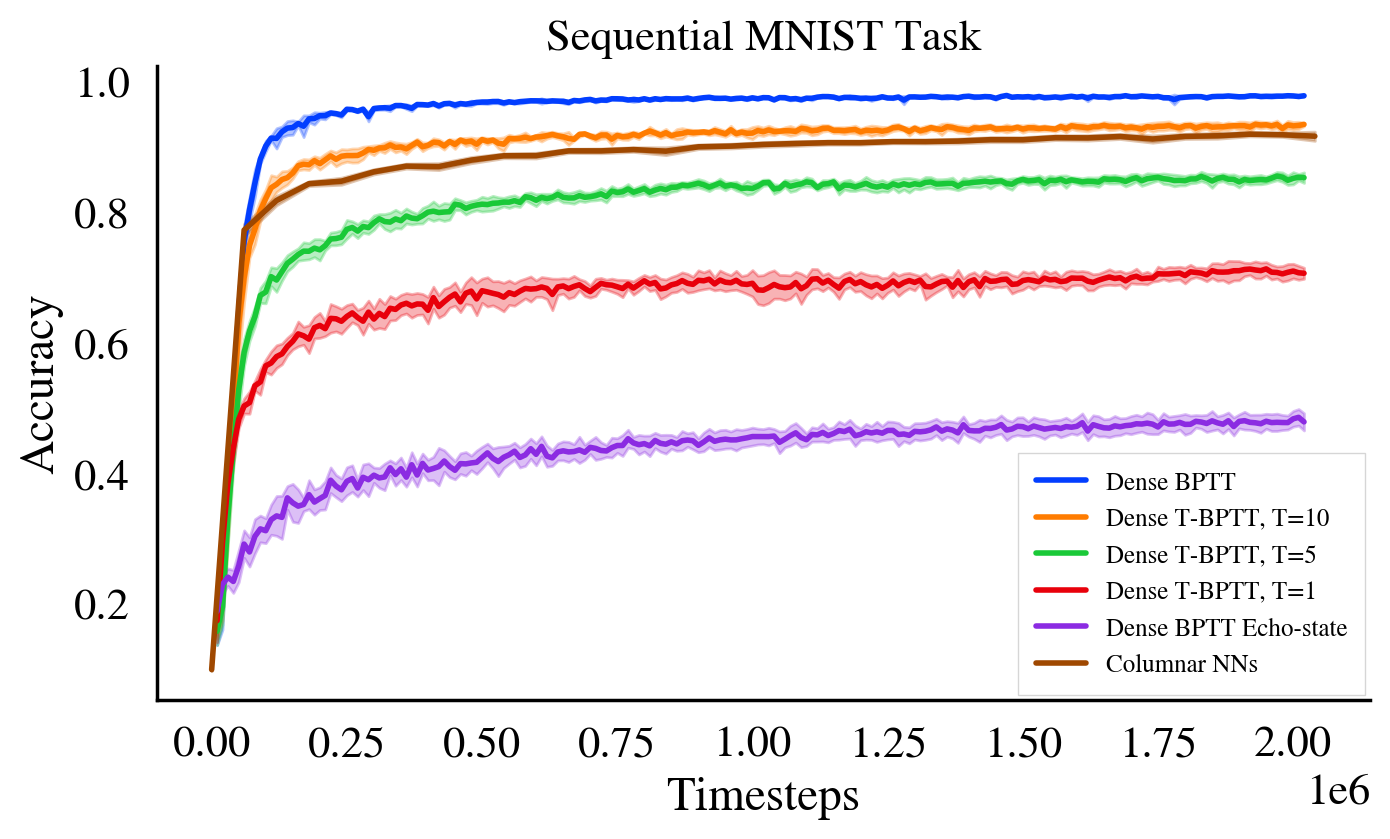

In [89]:
plt_name = f'Sequential MNIST Task'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

#TODO make 204
NENTRIES = 202 # num entries to plot
min_steps =  2000000 # min timesteps that should exist for a run to qualify
conditions = [['step_size', 0.05]]
plt_with_err(comment2, NENTRIES, min_steps, db2, colors[color_idx], "Dense BPTT", conditions)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 10]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=10", conditions)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 5]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=5", conditions)
color_idx+=1

conditions = [['step_size', 0.1], ['truncation_length', 1]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=1", conditions)
color_idx+=1

conditions = [['step_size', 0.5]]
plt_with_err(comment3, NENTRIES, min_steps, db3, colors[color_idx], "Dense BPTT Echo-state", conditions)
color_idx+=1

conditions = [['step_size', 1e-1],
             ['init', 1.0]]
plt_with_err("", 35, min_steps, db5, colors[color_idx], "Columnar NNs", conditions, "test_accuracy", pkey_col = "run", nocomment=True)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_sMNIST_test_only.pdf', bbox_inches='tight')
plt.show()

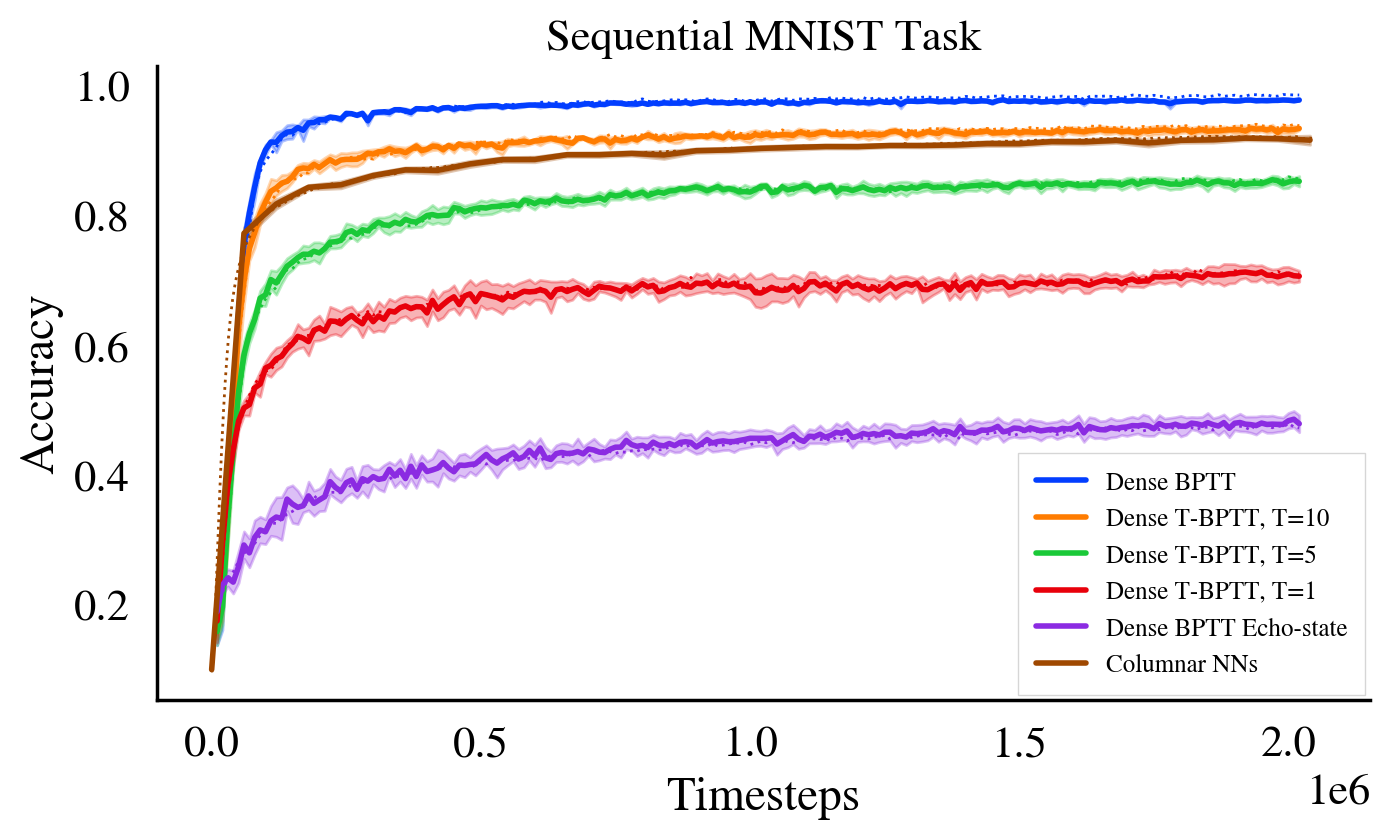

In [90]:
plt_name = f'Sequential MNIST Task'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

#TODO make 204
NENTRIES = 202 # num entries to plot
min_steps =  2000000 # min timesteps that should exist for a run to qualify
conditions = [['step_size', 0.05]]
plt_with_err(comment2, NENTRIES, min_steps, db2, colors[color_idx], "Dense BPTT", conditions)
plt_with_err(comment2, NENTRIES, min_steps, db2, colors[color_idx], "Training Dense BPTT", conditions, "training_metrics", False, ":", nolabel=True)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 10]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=10", conditions)
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Training Dense T-BPTT, T=10", conditions, "training_metrics", False, ":", nolabel=True)
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 5]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=5", conditions)
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Training Dense T-BPTT, T=5", conditions, "training_metrics", False, ":", nolabel=True)
color_idx+=1

conditions = [['step_size', 0.1], ['truncation_length', 1]]
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Dense T-BPTT, T=1", conditions)
plt_with_err(comment4, NENTRIES, min_steps, db4, colors[color_idx], "Training Dense T-BPTT, T=1", conditions, "training_metrics", False, ":", nolabel=True)
color_idx+=1

conditions = [['step_size', 0.5]]
plt_with_err(comment3, NENTRIES, min_steps, db3, colors[color_idx], "Dense BPTT Echo-state", conditions)
plt_with_err(comment3, NENTRIES, min_steps, db3, colors[color_idx], "Training Dense BPTT Echo-state", conditions, "training_metrics", False, ":", nolabel=True)
color_idx+=1

conditions = [['step_size', 1e-1],
             ['init', 1.0]]
plt_with_err("", 35, min_steps, db5, colors[color_idx], "Columnar NNs", conditions, "test_accuracy", pkey_col = "run", nocomment=True)
plt_with_err("", 2050, min_steps, db5, colors[color_idx], "Columnar NNs", conditions, "error_table", False, ":", pkey_col = "run", nocomment=True, nolabel=True)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_sMNIST.pdf', bbox_inches='tight')
plt.show()